In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=1000)

In [3]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [4]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [5]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [6]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7,976.189651,-5653.417795,2770.480464
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2,-462.261129,-5535.146877,3120.593645
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3,-2256.980451,-3543.426543,4789.552023
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5,2410.348516,-5537.896973,2027.697745
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4,-350.359001,-5579.067584,3056.287693


In [7]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [8]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [9]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [10]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-10-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000


In [11]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [12]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-12-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000,NaN
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000,NaN
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219,NaN
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000,62.0
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000,NaN


In [13]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [14]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians']]

In [15]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
0,978.775466,-5636.091653,2804.658708,NaN,0.000000,0.051444,3.848451
1,-2409.574733,-3746.291746,4555.094813,NaN,0.000000,0.000000,3.813544
2,985.603053,-5636.104757,2802.240317,NaN,0.563219,14.558765,4.757768
3,985.048333,-5636.202230,2802.239319,62.0,0.000000,7.665216,4.701917
4,977.761677,-5441.347041,3166.285755,NaN,0.000000,5.453106,3.246312


In [16]:
df.dropna(inplace=True)

In [17]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
3,985.048333,-5636.202230,2802.239319,62.0,0.0,7.665216,4.701917
8,1038.813807,-5617.560112,2820.199507,66.0,0.0,7.459438,0.713840
28,964.816679,-5298.686551,3403.335218,69.0,0.0,5.813217,4.066617
32,945.221036,-5275.068348,3445.265174,69.0,0.0,6.173328,2.089159
48,1043.049048,-5653.562549,2745.709415,61.0,0.0,6.276217,3.267256


# attention (en+de)

In [18]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, TimeDistributed, Lambda
# )
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler


# # Split data to prevent leakage
# train_size = int(len(df) * 0.8)
# train_data = df.iloc[:train_size]
# test_data = df.iloc[train_size:]

# # Scale separately to avoid data leakage
# scaler = MinMaxScaler()
# scaled_train = scaler.fit_transform(train_data)
# scaled_test = scaler.transform(test_data)

# # Function to create sequences with step size = seq_length
# def create_sequences(data, seq_length):
#     X, decoder_inputs, decoder_targets = [], [], []

#     for i in range(0, len(data) - seq_length, seq_length):  # Step size = seq_length
#         X.append(data[i:i+seq_length])  # Encoder input: Full sequence

#         # Decoder input: Start token + shifted sequence
#         start_token = np.zeros((1, data.shape[1]))  # Start token (1 row of zeros)
#         decoder_in = np.vstack([start_token, data[i+1:i+seq_length]])

#         # Decoder target: Shifted sequence
#         decoder_target = data[i+1:i+seq_length+1]

#         decoder_inputs.append(decoder_in)
#         decoder_targets.append(decoder_target)

#     return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)

# seq_length = 10  # Look at last 10 time steps
# X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
# X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

# # Transformer Encoder Block
# def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
#     attention = Dropout(dropout_rate)(attention)
#     attention = inputs + attention
#     attention = LayerNormalization(epsilon=1e-6)(attention)

#     ff_output = Dense(ff_dim, activation="relu")(attention)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# # Transformer Decoder Block with Causal Mask
# def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     # Define causal mask using Lambda layer
#     def create_causal_mask(seq_len):
#         mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # Lower triangular mask
#         return 1 - mask  # Invert: 1 where to mask, 0 where allowed

#     causal_mask = Lambda(lambda x: create_causal_mask(tf.shape(x)[1]))(inputs)

#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         attention_norm, attention_norm, attention_mask=causal_mask
#     )
#     attention1 = Dropout(dropout_rate)(attention1)
#     attention1 = inputs + attention1
#     attention1 = LayerNormalization(epsilon=1e-6)(attention1)

#     attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         query=attention1, key=encoder_outputs, value=encoder_outputs
#     )
#     attention2 = Dropout(dropout_rate)(attention2)
#     attention2 = attention1 + attention2
#     attention2 = LayerNormalization(epsilon=1e-6)(attention2)

#     ff_output = Dense(ff_dim, activation="relu")(attention2)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)

# # Build Transformer Model
# def build_transformer_model(input_shape, target_shape, num_heads=4, ff_dim=64):
#     encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
#     encoder_outputs = transformer_encoder(encoder_inputs, num_heads, ff_dim)
#     encoder_outputs = transformer_encoder(encoder_outputs, num_heads, ff_dim)

#     decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
#     decoder_outputs = transformer_decoder(decoder_inputs, encoder_outputs, num_heads, ff_dim)
#     decoder_outputs = transformer_decoder(decoder_outputs, encoder_outputs, num_heads, ff_dim)

#     # Preserve Temporal Structure with TimeDistributed
#     x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
#     outputs = TimeDistributed(Dense(target_shape[-1]))(x)  # Output per time step

#     model = Model([encoder_inputs, decoder_inputs], outputs)
#     return model

# # Define target shape correctly
# target_shape = (seq_length, X_train.shape[-1])  # Adjusted to match correct sequence length

# # Build model
# model = build_transformer_model((seq_length, X_train.shape[2]), target_shape, num_heads=4, ff_dim=64)

# # Compile Model
# model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# # Train Model
# history = model.fit(
#     [X_train, decoder_inputs_train], decoder_targets_train,
#     epochs=50, batch_size=16,
#     validation_data=([X_test, decoder_inputs_test], decoder_targets_test)
# )

# # Plot Training History
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.legend()
# plt.title("Training Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()


In [19]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
#     TimeDistributed, Lambda, Embedding
# )
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler
# import pandas as pd

# # Data Preprocessing
# train_size = int(len(df) * 0.8)
# train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# # Scale data separately to prevent leakage
# scaler = MinMaxScaler()
# scaled_train = scaler.fit_transform(train_data)
# scaled_test = scaler.transform(test_data)

# # Pad features to make even
# if scaled_train.shape[1] % 2 != 0:
#     scaled_train = np.hstack([scaled_train, np.zeros((scaled_train.shape[0], 1))])
#     scaled_test = np.hstack([scaled_test, np.zeros((scaled_test.shape[0], 1))])

# # Positional Encoding Layer

# class PositionalEncoding(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(PositionalEncoding, self).__init__(**kwargs)

#     def build(self, input_shape):
#         _, seq_len, d_model = input_shape

#         if d_model % 2 != 0:
#             raise ValueError(f"d_model must be even, but got {d_model}")

#         pos = np.arange(seq_len)[:, np.newaxis]
#         div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))

#         pe = np.zeros((seq_len, d_model))
#         pe[:, 0::2] = np.sin(pos * div_term)
#         pe[:, 1::2] = np.cos(pos * div_term)
#         self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

#     def call(self, inputs):
#         return inputs + self.pe[:, :tf.shape(inputs)[1], :]

#     def get_config(self):
#         config = super().get_config()
#         return config


# # Learned Start Token
# start_token_layer = Embedding(input_dim=1, output_dim=df.shape[1])

# def create_sequences(data, seq_length):
#     X, decoder_inputs, decoder_targets = [], [], []

#     for i in range(len(data) - seq_length - 1):
#         X.append(data[i:i+seq_length])

#         # Ensure start token matches feature dimension
#         start_token = start_token_layer(tf.zeros((1, 1), dtype=tf.int32)).numpy()[0]

#         # Adjust dimensions if needed
#         if start_token.shape[0] != data.shape[1]:
#             start_token = np.zeros((data.shape[1],))  # Ensure same shape

#         decoder_in = np.vstack([start_token, data[i+1:i+seq_length]])

#         # Decoder target
#         decoder_target = data[i+1:i+seq_length+1]

#         decoder_inputs.append(decoder_in)
#         decoder_targets.append(decoder_target)

#     return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)

# seq_length = 10  # Fixed step size
# X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
# X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

# # Ensure feature_dim is even
# # Remove these lines:
# feature_dim = X_train.shape[2]
# if feature_dim % 2 != 0:
#     feature_dim += 1

# # Transformer Encoder Block
# def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
#     attention = Dropout(dropout_rate)(attention)
#     attention = inputs + attention
#     attention = LayerNormalization(epsilon=1e-6)(attention)

#     ff_output = Dense(ff_dim, activation="relu")(attention)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# # Transformer Decoder Block with Corrected Causal Mask
# def create_causal_mask(seq_len):
#     mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
#     mask = tf.where(mask == 0, -np.inf, 0)
#     return mask

# def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     causal_mask = Lambda(lambda x: create_causal_mask(tf.shape(x)[1]))(inputs)

#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         attention_norm, attention_norm, attention_mask=causal_mask
#     )
#     attention1 = Dropout(dropout_rate)(attention1)
#     attention1 = inputs + attention1
#     attention1 = LayerNormalization(epsilon=1e-6)(attention1)

#     attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         query=attention1, key=encoder_outputs, value=encoder_outputs
#     )
#     attention2 = Dropout(dropout_rate)(attention2)
#     attention2 = attention1 + attention2
#     attention2 = LayerNormalization(epsilon=1e-6)(attention2)

#     ff_output = Dense(ff_dim, activation="relu")(attention2)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)

# # Build Transformer Model
# def build_transformer_model(input_shape, target_shape, num_heads=4, ff_dim=64):
#     encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
#     x = PositionalEncoding()(encoder_inputs)  # Add positional encoding
#     encoder_outputs = transformer_encoder(x, num_heads, ff_dim)
#     encoder_outputs = transformer_encoder(encoder_outputs, num_heads, ff_dim)

#     decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
#     x = PositionalEncoding()(decoder_inputs)  # Add positional encoding
#     decoder_outputs = transformer_decoder(x, encoder_outputs, num_heads, ff_dim)
#     decoder_outputs = transformer_decoder(decoder_outputs, encoder_outputs, num_heads, ff_dim)

#     x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
#     outputs = TimeDistributed(Dense(target_shape[-1]))(x)

#     return Model([encoder_inputs, decoder_inputs], outputs)

# # Define target shape correctly
# target_shape = (seq_length, X_train.shape[-1])


# # Train Model
# # Build model with corrected dimensions
# model = build_transformer_model(
#     (seq_length, scaled_train.shape[1]),  # Now has even features
#     (seq_length, scaled_train.shape[1]),   # Same for decoder
#     num_heads=4,
#     ff_dim=64
# )

# # Compile Model
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss="mse",
#     metrics=[tf.keras.metrics.MeanAbsoluteError()]
# )

# model.summary()

In [20]:
# # Train Model
# history = model.fit(
#     [X_train, decoder_inputs_train], decoder_targets_train,
#     epochs=50, batch_size=32,
#     validation_data=([X_test, decoder_inputs_test], decoder_targets_test)
# )

# # Plot Training History
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.legend()
# plt.title("Training Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

In [21]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Number of future steps
# future_steps = 10
# future_predictions = []

# # Initialize input sequence from the last test sample
# input_seq = X_test[-1].reshape(1, seq_length, X_train.shape[2])  # Match input shape

# for _ in range(future_steps):
#     pred = model.predict([input_seq, input_seq], verbose=0)  # Both encoder & decoder inputs

#     future_predictions.append(pred[0, -1, :])  # Take last predicted timestep

#     # Shift input sequence and insert new prediction
#     input_seq = np.roll(input_seq, -1, axis=1)
#     input_seq[0, -1, :] = future_predictions[-1]  # Insert prediction into last time step

# # Convert to NumPy array
# future_predictions = np.array(future_predictions)

# # 🔥 Remove the last feature (8th column) before inverse scaling
# future_predictions = future_predictions[:, :-1]  # Exclude last column

# # Convert predictions back to original scale
# future_predictions = scaler.inverse_transform(future_predictions)

# # ✅ Ensure column count matches predictions
# expected_columns = df.columns[:future_predictions.shape[1]]  # Select the correct number of columns

# # Create timestamps for predicted values
# forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# # 🔹 Plot Actual vs. Predicted Values
# plt.figure(figsize=(10, 5))
# plt.plot(df["x"], label="Actual X", color="blue")
# plt.plot(forecast_df["x"], label="Predicted X", color="red", linestyle="dashed")
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Value")
# plt.title("Future Predictions")
# plt.grid()
# plt.show()

# print(forecast_df)


In [22]:
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import pandas as pd
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
#     TimeDistributed, Embedding, Lambda
# )
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler

# # Normalize Data
# train_size = int(len(df) * 0.8)
# train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# scaler = MinMaxScaler()
# scaled_train = scaler.fit_transform(train_data)
# scaled_test = scaler.transform(test_data)

# # Ensure feature dimensions are even
# if scaled_train.shape[1] % 2 != 0:
#     scaled_train = np.hstack([scaled_train, np.zeros((scaled_train.shape[0], 1))])
#     scaled_test = np.hstack([scaled_test, np.zeros((scaled_test.shape[0], 1))])


# class PositionalEncoding(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(PositionalEncoding, self).__init__(**kwargs)

#     def build(self, input_shape):
#         _, seq_len, d_model = input_shape
#         pos = np.arange(seq_len)[:, np.newaxis]
#         div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))

#         pe = np.zeros((seq_len, d_model))
#         pe[:, 0::2] = np.sin(pos * div_term)
#         pe[:, 1::2] = np.cos(pos * div_term)
#         self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

#     def call(self, inputs):
#         return inputs + self.pe[:, :tf.shape(inputs)[1], :]

#     def get_config(self):
#         return super().get_config()

# # Learned Start Token
# start_token_layer = Embedding(input_dim=1, output_dim=df.shape[1])

# def create_sequences(data, seq_length):
#     X, decoder_inputs, decoder_targets = [], [], []

#     for i in range(len(data) - seq_length - 1):
#         X.append(data[i:i+seq_length])

#         # Generate a start token of the same feature shape
#         start_token = np.zeros((1, data.shape[1]))  # Ensuring shape (1, num_features)

#         decoder_in = np.vstack([start_token, data[i+1:i+seq_length]])
#         decoder_target = data[i+1:i+seq_length+1]

#         decoder_inputs.append(decoder_in)
#         decoder_targets.append(decoder_target)

#     return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)


# seq_length = 10  # Time window
# X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
# X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)



# def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
#     attention = Dropout(dropout_rate)(attention)
#     attention = inputs + attention
#     attention = LayerNormalization(epsilon=1e-6)(attention)

#     ff_output = Dense(ff_dim, activation="relu")(attention)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# def causal_attention_mask(batch_size, seq_length):
#     """
#     Creates a causal mask for self-attention to prevent attending to future time steps.
#     Shape: (batch_size, 1, seq_length, seq_length)
#     """
#     mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)  # Upper triangular mask
#     mask = tf.reshape(mask, (1, 1, seq_length, seq_length))  # Expand dims for multi-head attention
#     return tf.tile(mask, [batch_size, 1, 1, 1])  # Tile across the batch

# def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
#     input_dim = tf.keras.backend.int_shape(inputs)[-1]
#     key_dim = max(1, input_dim // num_heads)

#     # Self-attention with built-in causal mask
#     attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
#     attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         attention_norm, attention_norm
#     )
#     attention1 = Dropout(dropout_rate)(attention1)
#     attention1 = inputs + attention1
#     attention1 = LayerNormalization(epsilon=1e-6)(attention1)

#     # Cross-attention between decoder and encoder outputs
#     attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
#         query=attention1, key=encoder_outputs, value=encoder_outputs
#     )
#     attention2 = Dropout(dropout_rate)(attention2)
#     attention2 = attention1 + attention2
#     attention2 = LayerNormalization(epsilon=1e-6)(attention2)

#     # Feed-forward network
#     ff_output = Dense(ff_dim, activation="relu")(attention2)
#     ff_output = Dense(input_dim)(ff_output)
#     ff_output = Dropout(dropout_rate)(ff_output)

#     return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)


# def build_transformer_model(input_shape, target_shape):
#     encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
#     x = PositionalEncoding()(encoder_inputs)
#     encoder_outputs = transformer_encoder(x)

#     decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
#     x = PositionalEncoding()(decoder_inputs)
#     decoder_outputs = transformer_decoder(x, encoder_outputs)

#     x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
#     outputs = TimeDistributed(Dense(target_shape[-1]))(x)

#     return Model([encoder_inputs, decoder_inputs], outputs)

# model = build_transformer_model(
#     (seq_length, scaled_train.shape[1]),
#     (seq_length, scaled_train.shape[1])
# )

# model.compile(optimizer=Adam(learning_rate=0.001), loss="msle", metrics=['accuracy'])
# model.summary()

# # Train model
# model.fit(
#     [X_train, decoder_inputs_train], decoder_targets_train,
#     validation_data=([X_test, decoder_inputs_test], decoder_targets_test),
#     epochs=20, batch_size=32
# )


In [23]:
# def causal_attention_mask(batch_size, seq_length):
#     mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)  # Upper triangular mask
#     mask = tf.reshape(mask, (1, 1, seq_length, seq_length))  # Expand dims for multi-head attention
#     return tf.tile(mask, [batch_size, 1, 1, 1])  # Tile across the batch


In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
    TimeDistributed, Embedding
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


# Normalize Data
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Ensure feature dimensions are even
if scaled_train.shape[1] % 2 != 0:
    scaled_train = np.hstack([scaled_train, np.zeros((scaled_train.shape[0], 1))])
    scaled_test = np.hstack([scaled_test, np.zeros((scaled_test.shape[0], 1))])

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def build(self, input_shape):
        seq_len, d_model = input_shape[1], input_shape[2]

        pos = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))

        pe = np.zeros((seq_len, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)

        self.pe = self.add_weight(
            shape=(1, seq_len, d_model),
            initializer=tf.keras.initializers.Constant(pe),
            trainable=False
        )

    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]

# Learned Start Token (Use a trainable variable instead of Embedding)
start_token_layer = tf.Variable(tf.random.normal((1, df.shape[1])), trainable=True)

def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []
    for i in range(len(data) - 2*seq_length - 1):  # Ensure enough data
        # Encoder input: current window
        X.append(data[i:i+seq_length])

        # Start token = last element of encoder input
        start_token = data[i+seq_length-1]  # Key fix

        # Decoder input: start token + next seq_length-1 steps
        decoder_in = np.vstack([
            start_token,
            data[i+seq_length:i+seq_length+seq_length-1]  # Future steps
        ])

        # Target: steps after encoder input
        decoder_target = data[i+seq_length:i+seq_length+seq_length]

        decoder_inputs.append(decoder_in)
        decoder_targets.append(decoder_target)

    return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)

seq_length = 10  # Time window
X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
    attention = Dropout(dropout_rate)(attention)
    attention = inputs + attention
    attention = LayerNormalization(epsilon=1e-6)(attention)

    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention + ff_output)


def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    # Generate causal mask using a Lambda layer
    causal_mask = tf.keras.layers.Lambda(
        lambda x: tf.tile(
            tf.reshape(
                tf.linalg.band_part(tf.ones((tf.shape(x)[1], tf.shape(x)[1])), -1, 0),
                (1, 1, tf.shape(x)[1], tf.shape(x)[1])
            ),
            [tf.shape(x)[0], 1, 1, 1]
        )
    )(inputs)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        attention_norm, attention_norm, attention_mask=causal_mask
    )
    attention1 = Dropout(dropout_rate)(attention1)
    attention1 = inputs + attention1
    attention1 = LayerNormalization(epsilon=1e-6)(attention1)

    # Project encoder outputs for better integration
    encoder_projection = Dense(input_dim)(encoder_outputs)

    # Cross-attention between decoder and encoder outputs
    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        query=attention1, key=encoder_projection, value=encoder_projection
    )
    attention2 = Dropout(dropout_rate)(attention2)
    attention2 = attention1 + attention2
    attention2 = LayerNormalization(epsilon=1e-6)(attention2)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation="relu")(attention2)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention2 + ff_output)

def build_transformer_model(input_shape, target_shape):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    x = PositionalEncoding()(encoder_inputs)
    encoder_outputs = transformer_encoder(x)

    decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
    x = PositionalEncoding()(decoder_inputs)
    decoder_outputs = transformer_decoder(x, encoder_outputs)

    x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
    outputs = TimeDistributed(Dense(target_shape[-1]))(x)

    return Model([encoder_inputs, decoder_inputs], outputs)

model = build_transformer_model(
    (seq_length, scaled_train.shape[1]),
    (seq_length, scaled_train.shape[1])
)

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
model.summary()

# Train model
model.fit(
    [X_train, decoder_inputs_train], decoder_targets_train,
    validation_data=([X_test, decoder_inputs_test], decoder_targets_test),
    epochs=20, batch_size=32
)




Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_6     │ (None, 10, 8)          │             80 │ encoder_inputs[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_21    │ (None, 10, 8)          │             16 │ positional_encoding_6… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 10, 8)          │            288 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 10, 8)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 10, 8)          │              0 │ positional_encoding_6… │
│                           │                        │                │ dropout_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_22    │ (None, 10, 8)          │             16 │ add_15[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_7     │ (None, 10, 8)          │             80 │ decoder_inputs[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 10, 64)         │            576 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_24    │ (None, 10, 8)          │             16 │ positional_encoding_7… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1, 10, 10)      │              0 │ positional_encoding_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 10, 8)          │            520 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_10   │ (None, 10, 8)          │            288 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
│                           │                        │                │ lambda_3[0][0]         │
├──────────────────────

 Total params: 3,952 (15.44 KB)

 Trainable params: 3,792 (14.81 KB)

 Non-trainable params: 160 (640.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step - accuracy: 0.0046 - loss: 0.8144 - val_accuracy: 0.0000e+00 - val_loss: 2736434.7500
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0135 - loss: 0.6943 - val_accuracy: 0.0000e+00 - val_loss: 2736452.5000
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0205 - loss: 0.5910 - val_accuracy: 0.0000e+00 - val_loss: 2736460.5000
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0375 - loss: 0.5169 - val_accuracy: 0.0667 - val_loss: 2736463.5000
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0514 - loss: 0.4537 - val_accuracy: 0.1333 - val_loss: 2736463.0000
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.0793 - loss: 0.3994 - val_accuracy: 0.2667 - val_loss: 2736456.7500
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1127 - loss: 0.3450 - val_accuracy: 0.3667 - val_loss: 2736451.0000
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1853 -

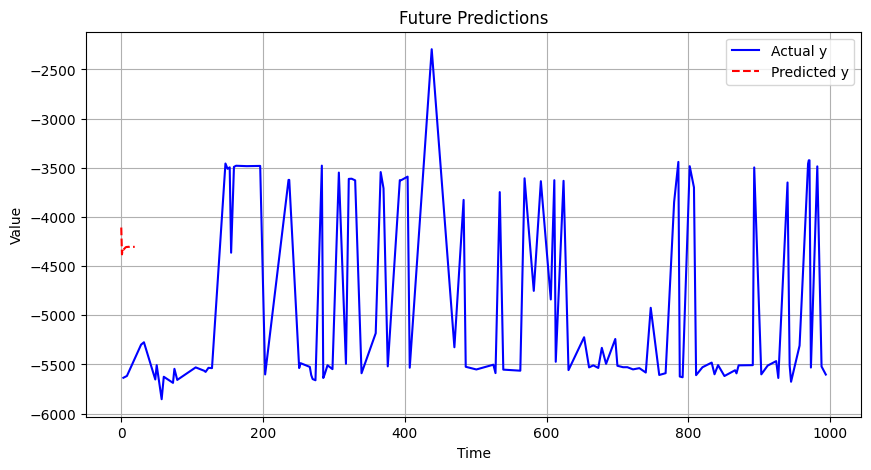

In [41]:
future_steps = 20
future_predictions = []

# Initialize input sequence (keep encoder input fixed)
encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])

# Initialize decoder input with a start token (can be zeros or last known value)
decoder_input = np.zeros((1, seq_length, X_train.shape[2]))

for step in range(future_steps):
    # Predict next step
    pred = model.predict([encoder_input, decoder_input], verbose=0)

    # Extract last predicted time step
    next_pred = pred[0, -1, :]

    # Store prediction
    future_predictions.append(next_pred)

    # Shift decoder input and insert new prediction
    decoder_input = np.roll(decoder_input, -1, axis=1)
    decoder_input[0, -1, :] = next_pred  # Insert new prediction at last timestep

# Convert to NumPy array
future_predictions = np.array(future_predictions)

#  Remove the last extra column before inverse transform
future_predictions = future_predictions[:, :-1]  # Ensure same feature size

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

#  Ensure column count matches predictions
expected_columns = df.columns[:future_predictions.shape[1]]  # Select the correct number of columns

# Create timestamps for predicted values
forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# 🔹 Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(df["y"], label="Actual y", color="blue")
plt.plot(forecast_df["y"], label="Predicted y", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()


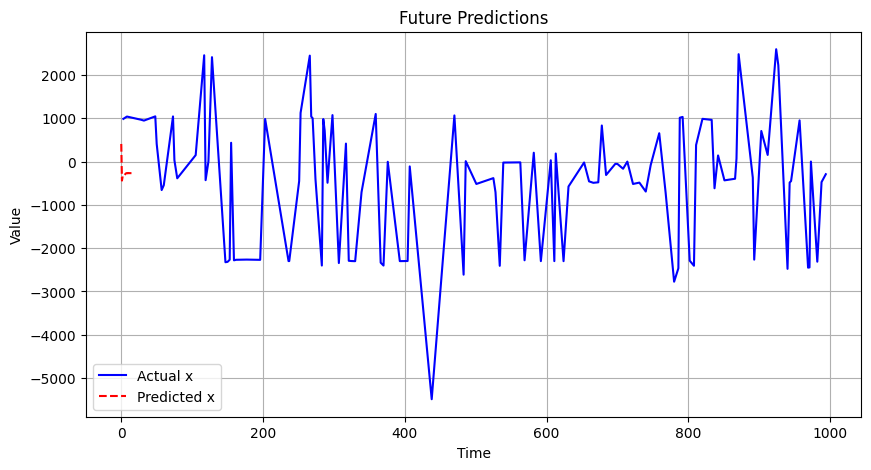

In [42]:
future_steps = 20
future_predictions = []

# Initialize input sequence (keep encoder input fixed)
encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])

# Initialize decoder input with a start token (can be zeros or last known value)
decoder_input = np.zeros((1, seq_length, X_train.shape[2]))

for step in range(future_steps):
    # Predict next step
    pred = model.predict([encoder_input, decoder_input], verbose=0)

    # Extract last predicted time step
    next_pred = pred[0, -1, :]

    # Store prediction
    future_predictions.append(next_pred)

    # Shift decoder input and insert new prediction
    decoder_input = np.roll(decoder_input, -1, axis=1)
    decoder_input[0, -1, :] = next_pred  # Insert new prediction at last timestep

# Convert to NumPy array
future_predictions = np.array(future_predictions)

#  Remove the last extra column before inverse transform
future_predictions = future_predictions[:, :-1]  # Ensure same feature size

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

#  Ensure column count matches predictions
expected_columns = df.columns[:future_predictions.shape[1]]  # Select the correct number of columns

# Create timestamps for predicted values
forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# 🔹 Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(df["x"], label="Actual x", color="blue")
plt.plot(forecast_df["x"], label="Predicted x", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()


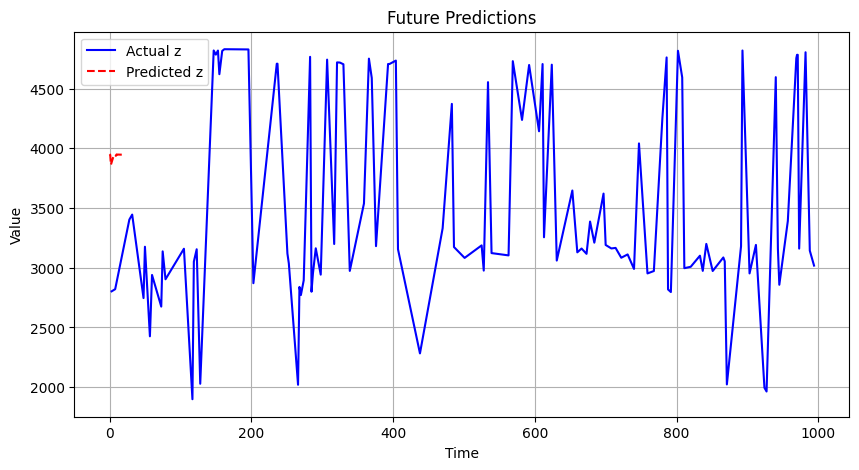

In [43]:
future_steps = 20
future_predictions = []

# Initialize input sequence (keep encoder input fixed)
encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])

# Initialize decoder input with a start token (can be zeros or last known value)
decoder_input = np.zeros((1, seq_length, X_train.shape[2]))

for step in range(future_steps):
    # Predict next step
    pred = model.predict([encoder_input, decoder_input], verbose=0)

    # Extract last predicted time step
    next_pred = pred[0, -1, :]

    # Store prediction
    future_predictions.append(next_pred)

    # Shift decoder input and insert new prediction
    decoder_input = np.roll(decoder_input, -1, axis=1)
    decoder_input[0, -1, :] = next_pred  # Insert new prediction at last timestep

# Convert to NumPy array
future_predictions = np.array(future_predictions)

#  Remove the last extra column before inverse transform
future_predictions = future_predictions[:, :-1]  # Ensure same feature size

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

#  Ensure column count matches predictions
expected_columns = df.columns[:future_predictions.shape[1]]  # Select the correct number of columns

# Create timestamps for predicted values
forecast_df = pd.DataFrame(future_predictions, columns=expected_columns)

# 🔹 Plot Actual vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(df["z"], label="Actual z", color="blue")
plt.plot(forecast_df["z"], label="Predicted z", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()


In [31]:
# # CORRECTED PREDICTION LOOP
# def generate_predictions(model, encoder_input, future_steps):
#     # Initialize decoder input with repeated start token
#     start_token = encoder_input[:, -1:, :]  # Last element of encoder input
#     decoder_input = np.tile(start_token, (1, seq_length, 1))

#     future_predictions = []
#     for _ in range(future_steps):
#         pred = model.predict([encoder_input, decoder_input], verbose=0)
#         next_step = pred[:, -1:, :]  # Take last predicted step

#         # Shift decoder input and append prediction
#         decoder_input = np.roll(decoder_input, shift=-1, axis=1)
#         decoder_input[:, -1:, :] = next_step

#         future_predictions.append(next_step.squeeze())

#     return np.array(future_predictions)

# # Usage
# encoder_input = X_test[-1].reshape(1, seq_length, -1)
# future_predictions = generate_predictions(model, encoder_input, future_steps=10)
# print(future_predictions)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_15    │ (None, 10, 8)          │              0 │ encoder_inputs[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_49    │ (None, 10, 8)          │             16 │ positional_encoding_1… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_21   │ (None, 10, 8)          │            288 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_57 (Dropout)      │ (None, 10, 8)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_35 (Add)              │ (None, 10, 8)          │              0 │ positional_encoding_1… │
│                           │                        │                │ dropout_57[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_50    │ (None, 10, 8)          │             16 │ add_35[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_encoding_16    │ (None, 10, 8)          │              0 │ decoder_inputs[0][0]   │
│ (PositionalEncoding)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_49 (Dense)          │ (None, 10, 64)         │            576 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_52    │ (None, 10, 8)          │             16 │ positional_encoding_1… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 10, 8)          │            520 │ dense_49[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_22   │ (None, 10, 8)          │            288 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_58 (Dropout)      │ (None, 10, 8)          │              0 │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_60 (Dropout) 

 Total params: 3,792 (14.81 KB)

 Trainable params: 3,792 (14.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 764ms/step - accuracy: 0.2588 - loss: 0.3494 - val_accuracy: 0.3000 - val_loss: 2736291.2500
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3247 - loss: 0.2718 - val_accuracy: 0.3667 - val_loss: 2736309.0000
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3580 - loss: 0.2166 - val_accuracy: 0.4000 - val_loss: 2736324.2500
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3738 - loss: 0.1747 - val_accuracy: 0.4667 - val_loss: 2736343.2500
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3544 - loss: 0.1508 - val_accuracy: 0.4667 - val_loss: 2736356.0000
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3836 - loss: 0.1263 - val_accuracy: 0.4667 - val_loss: 2736368.5000
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4314 - loss: 0.1089 - val_accuracy: 0.5000 - val_loss: 2736380.2500
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4802 - loss: 0.094

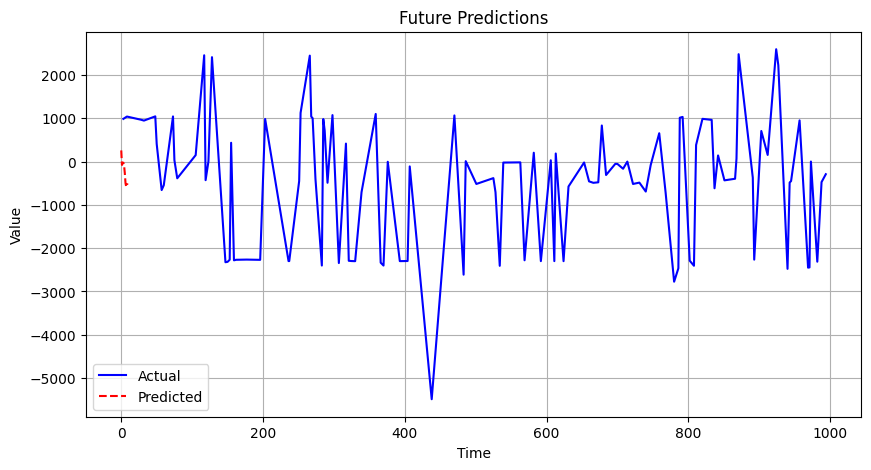

In [50]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout,
    TimeDistributed, Embedding, Add
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load dataset (Ensure df is preloaded)

# Normalize Data
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# Ensure feature dimensions are even
if scaled_train.shape[1] % 2 != 0:
    scaled_train = np.hstack([scaled_train, np.zeros((scaled_train.shape[0], 1))])
    scaled_test = np.hstack([scaled_test, np.zeros((scaled_test.shape[0], 1))])

# **Fix: Correct Positional Encoding**
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_seq_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_seq_length = max_seq_length
        self.d_model = d_model

        # Create a fixed positional encoding matrix
        pos = np.arange(max_seq_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))

        pe = np.zeros((max_seq_length, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)

        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pe[: tf.shape(inputs)[1], :]

def create_sequences(data, seq_length):
    X, decoder_inputs, decoder_targets = [], [], []
    for i in range(len(data) - 2*seq_length - 1):  # Ensure enough data
        X.append(data[i:i+seq_length])

        # Start token = last element of encoder input
        start_token = data[i+seq_length-1]

        # Decoder input: start token + next seq_length-1 steps
        decoder_in = np.vstack([
            start_token,
            data[i+seq_length:i+seq_length+seq_length-1]
        ])

        # Target: steps after encoder input
        decoder_target = data[i+seq_length:i+seq_length+seq_length]

        decoder_inputs.append(decoder_in)
        decoder_targets.append(decoder_target)

    return np.array(X), np.array(decoder_inputs), np.array(decoder_targets)

seq_length = 10
X_train, decoder_inputs_train, decoder_targets_train = create_sequences(scaled_train, seq_length)
X_test, decoder_inputs_test, decoder_targets_test = create_sequences(scaled_test, seq_length)

def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention_norm, attention_norm)
    attention = Dropout(dropout_rate)(attention)
    attention = Add()([inputs, attention])  # Residual connection
    attention = LayerNormalization(epsilon=1e-6)(attention)

    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(Add()([attention, ff_output]))  # Residual connection

def transformer_decoder(inputs, encoder_outputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    input_dim = tf.keras.backend.int_shape(inputs)[-1]
    key_dim = max(1, input_dim // num_heads)

    # Causal mask
    # causal_mask = tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)
    causal_mask = tf.linalg.band_part(tf.ones((1, seq_length, seq_length)), -1, 0)


    attention_norm = LayerNormalization(epsilon=1e-6)(inputs)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        attention_norm, attention_norm, attention_mask=causal_mask
    )
    attention1 = Dropout(dropout_rate)(attention1)
    attention1 = Add()([inputs, attention1])  # Residual connection
    attention1 = LayerNormalization(epsilon=1e-6)(attention1)

    encoder_projection = Dense(input_dim)(encoder_outputs)

    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
        query=attention1, key=encoder_projection, value=encoder_projection
    )
    attention2 = Dropout(dropout_rate)(attention2)
    attention2 = Add()([attention1, attention2])  # Residual connection
    attention2 = LayerNormalization(epsilon=1e-6)(attention2)

    ff_output = Dense(ff_dim, activation="relu")(attention2)
    ff_output = Dense(input_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(Add()([attention2, ff_output]))  # Residual connection

def build_transformer_model(input_shape, target_shape):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    x = PositionalEncoding(input_shape[0], input_shape[1])(encoder_inputs)
    encoder_outputs = transformer_encoder(x)

    decoder_inputs = Input(shape=target_shape, name="decoder_inputs")
    x = PositionalEncoding(target_shape[0], target_shape[1])(decoder_inputs)
    decoder_outputs = transformer_decoder(x, encoder_outputs)

    x = TimeDistributed(Dense(32, activation="relu"))(decoder_outputs)
    outputs = TimeDistributed(Dense(target_shape[-1]))(x)

    return Model([encoder_inputs, decoder_inputs], outputs)

model = build_transformer_model(
    (seq_length, scaled_train.shape[1]),
    (seq_length, scaled_train.shape[1])
)

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])
model.summary()

# Train model
model.fit(
    [X_train, decoder_inputs_train], decoder_targets_train,
    validation_data=([X_test, decoder_inputs_test], decoder_targets_test),
    epochs=20, batch_size=32
)

# Predict future values
# future_steps = 10
# future_predictions = []

# encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])
# decoder_input = np.zeros((1, seq_length, X_train.shape[2]))

# for step in range(future_steps):
#     pred = model.predict([encoder_input, decoder_input], verbose=0)
#     next_pred = pred[0, -1, :]
#     future_predictions.append(next_pred)
#     decoder_input = np.roll(decoder_input, -1, axis=1)
#     decoder_input[0, -1, :] = next_pred

future_steps = 10
future_predictions = []

encoder_input = X_test[-1].reshape(1, seq_length, X_train.shape[2])
decoder_input = decoder_inputs_test[-1].reshape(1, seq_length, X_train.shape[2])

for step in range(future_steps):
    pred = model.predict([encoder_input, decoder_input], verbose=0)
    next_pred = pred[0, -1, :]  # Get last time step output

    future_predictions.append(next_pred)

    # Shift decoder_input left and insert new prediction at the end
    decoder_input = np.roll(decoder_input, -1, axis=1)
    decoder_input[0, -1, :] = next_pred  # Replace last step


future_predictions = np.array(future_predictions)
future_predictions = scaler.inverse_transform(future_predictions[:, :-1])

forecast_df = pd.DataFrame(future_predictions, columns=df.columns[:future_predictions.shape[1]])

plt.figure(figsize=(10, 5))
plt.plot(df.index, df.iloc[:, 0], label="Actual", color="blue")
plt.plot(forecast_df.index, forecast_df.iloc[:, 0], label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Future Predictions")
plt.grid()
plt.show()
